In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
# parameter_values = get_parameter_values()

parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [3]:
parameter_values.search("maximum con")

Maximum concentration in negative electrode [mol.m-3]	28746.0
Maximum concentration in positive electrode [mol.m-3]	35380.0


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
parameter_values.update(
    {
    "Electrode width [m]":0.1,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
       "Nominal cell capacity [A.h]":2.5,
        "Maximum concentration in positive electrode [mol.m-3]":37500,
        "Positive electrode thickness [m]":5.45e-05,
        
    }
)

In [6]:
cell = 152002

## Load eSOH Data and OCV Data

In [7]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

Temp=45
dfe.N.iloc[-1]

892

In [8]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min",)
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
eps_n_data

0.6571914969631569

In [9]:
# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 9.0638e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]": 8.7257e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]": 1.77e-15, #4.352126e-16, #4.196499e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 3.07e-20, #3.6864e-19, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 0, #5997.629, #1.87422275e+04,1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 4.543e-10,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 1.3e02,
        
    #Cathode disolution
        "Positive electrode dissolution exchange current density": 5.85309e-4,
        "Negative electrode dissolution exchange current density": 0,
                
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 15.5,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0,
             
        
        
    },
    check_already_exists=False,
)


In [10]:
SOC_0=0
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

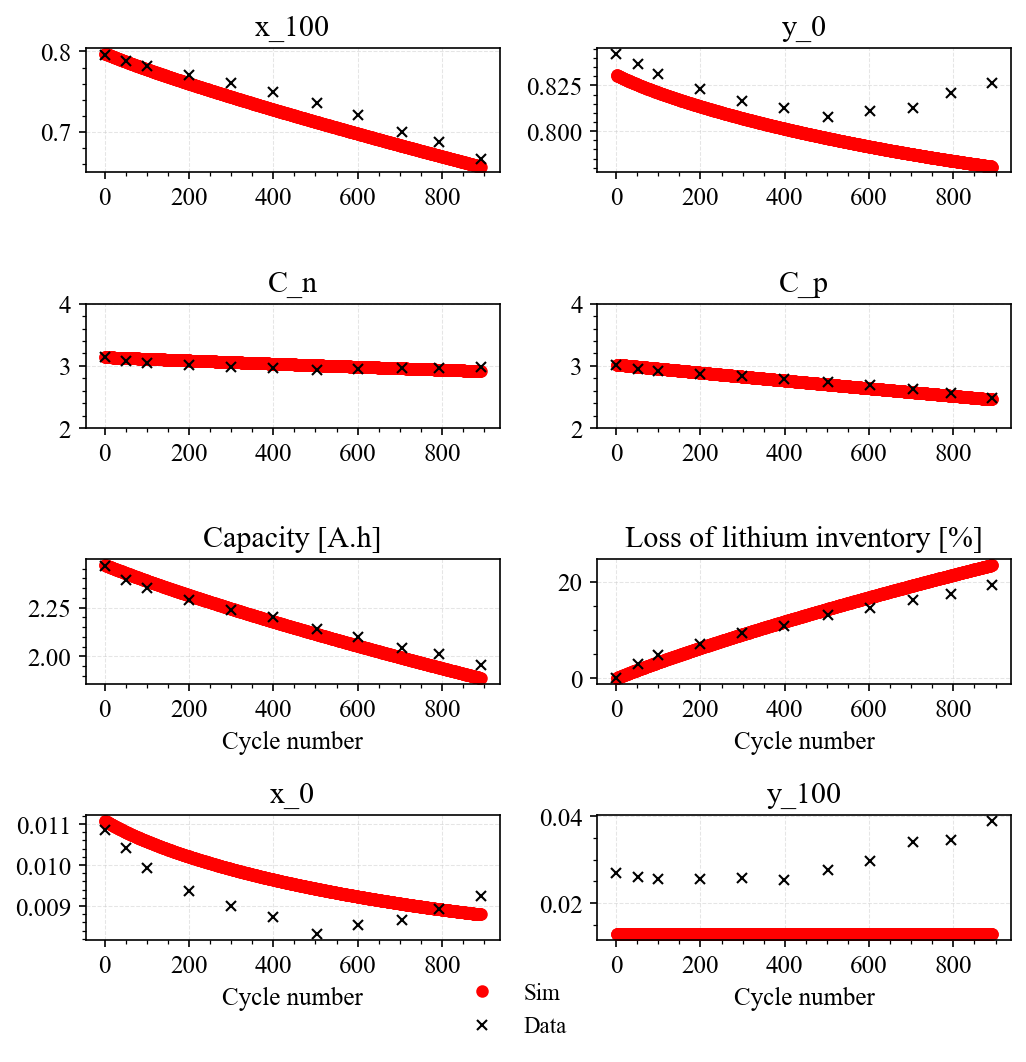

In [11]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [12]:
dir(all_sumvars_dict)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [13]:
# gegsg

# Parameter Fitting

## List of Initial Conditions

In [14]:
# pybamm.set_logging_level("NOTICE")


ic = 1
blam_p = [1e-6,1e-7,1e-8]
blam_n = [1e-6,1e-7,1e-8]
# k_sei= [1*2e-16,1/5*2e-16,5*2e-16]
k_pl = 1e-9
 # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]","x_100","y_0"]
    # weights = [1,1/20,5,5]

In [15]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    # variables = ["C_n","C_p","x_100","y_0"]
    # weights = [1,1,5,5]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # # weights = [1,1/20]
    variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]    
    weights = [1/2.5,1/10,1,1]             
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Lithium plating kinetic rate constant [m.s-1]": x[3]*k_pl,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+45,
            "Ambient temperature [K]": 273.15+45,
        },
        check_already_exists=False,
    )
    summvvar=cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1)
    return summvvar
def prediction_error(x):
#     try:
    out=[]
    cell=152002
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    Temp=45 #Ha
    SOC_0=0 #Ha
    print(eps_n_data)
    print(eps_p_data)
    print(Temp)
    print(SOC_0)
    # print(f"Cell: {cell_no}")
    experiment = pybamm.Experiment(
        [
          ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
#     x15 = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)

#         plotc(model,dfe)

    print(f"Objective")
    out_t =   multi_objective(pd.DataFrame(model), dfe)
    print(f"Concat")
    out=np.concatenate([out,out_t])
    print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
#     except:
#         out=[]
#         for cell in [152002]:
#             cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
#             # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
#             out_t = np.concatenate([np.array(dfe['Cap'])]*4)
#             out=np.concatenate([out, out_t])
#         out = 2*np.ones_like(out)
#         print(f"Error")
#         print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,0.8,0.51,0.4])
    # print(prediction_error(x0))
    lower = np.array([1e-3, 1e-3, 0.51, 1e-2])
    upper = np.array([1e+3, 1e+3, 2.0, 1e+2])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
#     model, out= prediction_error(x0)
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
#     solflag=soln_dfols.flag 
#     print(solflag)
    return soln_dfols
#     return model
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
#     solflag=soln_dfols.flag 
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
#     print(solflag)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    df['x_3'][0]=round(xsol[3],4)*k_pl
    df['obj'][0]=soln_dfols.f
#     return xsol
    return xsol ,df

In [16]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','x_3','obj'], index=[0])

In [17]:
train_len = len(N)
x12,df_x12 = sim_train(df_x)
# x12 = sim_train(df_x)
# len(N)

0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[1.   0.8  0.51 0.4 ], norm=0.7345144901186007
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[0.90358839 0.77374536 0.51       0.40393634], norm=0.617792642418872
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[1.00169907 0.77910107 0.51       0.30222297], norm=0.5628481288924013
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[1.02649366 0.70579847 0.51       0.42059508], norm=0.7654099019270509
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[1.   0.8  0.61 0.4 ], norm=0.49735584288722884
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[0.97534006 0.83843739 0.56516875 0.32315852], norm=0.45845084299170813
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[0.79550446 0.93708113 0.51       0.27667206], norm=0.43911818220534526
0.6571914969631569
0.551193680545816
45
0
Objective
Concat
x=[0.78182853 0.89749886 0.51       0.27615738], norm=0.4361205

In [18]:
# # dfe
# x13=pd.DataFrame(x12)
# np.array(x13.loc[dfe['N_mod']]["Capacity [A.h]"]) 

In [19]:
.fgdfdfg

SyntaxError: invalid syntax (1374486524.py, line 1)

In [ ]:
df_x12

In [ ]:
sim_des="plating_Andrew_dissol_mar23"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

In [ ]:
def plotcn(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n_loss", "C_p_loss", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    all_sumvars_dict["C_n_loss"] = (all_sumvars_dict["C_n"][0]-all_sumvars_dict["C_n"])/all_sumvars_dict["C_n"][0]*100
    all_sumvars_dict["C_p_loss"] = (all_sumvars_dict["C_p"][0]-all_sumvars_dict["C_p"])/all_sumvars_dict["C_p"][0]*100
    esoh_data["C_n_loss"] = (esoh_data["C_n"][0]-esoh_data["C_n"])/esoh_data["C_n"][0]*100
    esoh_data["C_p_loss"] = (esoh_data["C_p"][0]-esoh_data["C_p"])/esoh_data["C_p"][0]*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        # if k ==2 or k==3:
        #     ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sim"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
for cell in [152002]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    SOC_0=0
    Temp=45
    experiment = pybamm.Experiment(
        [
           ( "Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
    sol_out = simulate(x12,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotcn(sol_out,dfe);
#     plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

In [ ]:
df_x

In [ ]:
Temp

In [ ]:
x

In [ ]:
parameter_values.search("")

In [ ]:



sim_long_Abdrew = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long_Abdrew = sim_long_Abdrew.solve(initial_soc=0, save_at_cycles=20  )


In [ ]:
pybamm.plot_summary_variables(sol_long_Abdrew)

In [ ]:
sol_long=sol_long_Abdrew
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,

In [ ]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
    
       }
savemat("Andrew_experiment_feb13_2.mat",mdic)

In [ ]:
print(parameter_values.search("max"))
print(parameter_values.search("EC "))
print(parameter_values.search("plating"))
print(parameter_values.search("SEI"))
print(parameter_values.search("LAM"))
print(SOC_0)
print(Temp)

In [ ]:
print(eps_n_data)

In [ ]:
print(eps_p_data)

In [ ]:
parameter_values.search("")